# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the seven-qubit Steane code

In [5]:
import collections
from typing import List, Dict, Sequence
import itertools
import functools

import numpy as np
import cirq
import qiskit
from qiskit.circuit.library import Barrier
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

from mitiq import PauliString

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

In [6]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [7]:
n = 7                                   # Number of physical qubits
nshots = 20_000                         # Number of samples/shots
depths = np.arange(0, 100 + 1, 10)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.

In [8]:
# Computer and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend("ibm_kyiv")
sampler = Sampler(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
# layout = {
#     # 7: [48, 49, 50, 55, 67, 68, 69]
#     # 7: [99, 100, 101, 110, 117, 118, 119]
#     7 : [3, 2, 1, 0, 14, 18, 19],
# }


# Good qubits in Sherbrooke Jan 24.
layout = {
    7 : [99, 100, 101, 110, 117, 118, 119],
}

## Helper functions

In [9]:
def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
    qubit_counts = collections.Counter()
    for key, value in counts.items():
        k = list(key)[qubit]
        qubit_counts[int(k)] += value
    return qubit_counts


# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

# Prepares logical |0> state on Steane Code
def encode_steane(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on(qreg[0]))
    circuit.append(cirq.H.on(qreg[4]))
    circuit.append(cirq.H.on(qreg[6]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[5]))

    circuit.append(cirq.CNOT.on(qreg[6], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[6], qreg[5]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[2]))
    
    circuit.append(cirq.CNOT.on(qreg[0], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[3], qreg[2]))

    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [10]:
qreg = cirq.LineQubit.range(n)

to_run_raw = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[n],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )
    to_run_raw.append(compiled_raw)

In [11]:
to_run_raw[-1].draw(fold=-1, idle_wires=False)

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░ ┌─┐                  
 q_0 -> 99 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤M├──────────────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░ └╥┘┌─┐               
q_1 -> 100 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫─┤M├───────────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░  ║ └╥┘┌─┐            
q_2 -> 101 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫──╫─┤M├────────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░  ║  ║ └╥┘┌─┐         
q_3 -> 110 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X

In [12]:
job_raw = sampler.run(
    to_run_raw,
    shots=nshots,
)
# job_raw = service.job("cu991vo0uvgc73as1dig")

In [13]:
all_counts_raw = [result.data.measure.get_counts() for result in job_raw.result()]

In [14]:
all_evals = {}

for i, q in enumerate(layout[n]):
    evals = []
    for counts in all_counts_raw:
        counts = get_counts_for(i, counts)
        eval = (counts.get(0, 0) - counts.get(1, 0)) / nshots
        evals.append(eval)
    all_evals[q] = evals

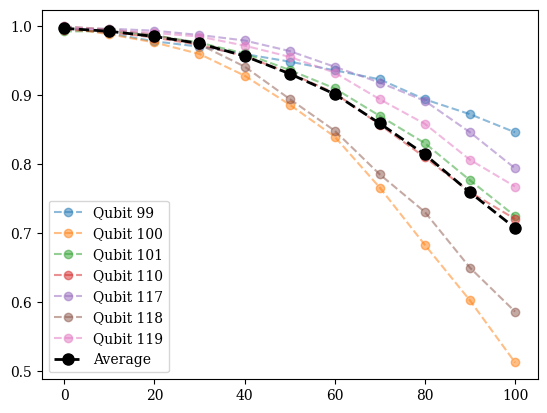

In [15]:
for qubit, evals in all_evals.items():
    plt.plot(depths, evals, "--o", alpha=0.5, label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths, evals_raw_avg, "--o", ms=8, lw=2, color="black", label="Average")
plt.legend();
plt.savefig("physical_evals.pdf")

# Run encoded experiment

In [16]:
generator_strs = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]
observable = PauliString("Z" * n)._pauli
qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)
# print(measurement_circuit)


In [17]:
encoding = encode_steane(qreg)
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

measurement = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit.to_qasm())

circ_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement)
circ_full.measure_active()

compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

compiled.draw(fold=-1, idle_wires=False)
# compiled.count_ops()

global phase: 3π/4
           ┌─────────┐ ┌────┐┌───────────────┐┌────┐┌──────────┐┌──────┐  ┌──────────┐ ┌────┐┌──────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                                     ┌──────┐  ┌──────────┐ ┌────┐ ┌──────────────┐                                                                                                                                                                                                 encoding  measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐  ┌────┐                                                     ┌──────┐   ┌──────────┐     ┌────┐    ┌─────────┐ ┌──────┐   ┌────┐  ┌─────────────┐ ┌────┐ ┌─────────┐                                                                                                                                                                                                                                 ┌──────┐   ┌──────────┐   ┌────┐   ┌─────────────┐   ┌────┐   ┌──────────┐                                                                                                                                                                                                                                                                       ┌──────┐  ┌─────────┐   ┌────┐   ┌─────────────┐     ┌────┐     ┌─────────┐                                                                                                                                                                                                                              ░ ┌─┐                  
 q_0 -> 99 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.036806) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├─┤ √X ├┤ Rz(-0.85613) ├┤ √X ├┤ Rz(-π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├─┤ √X ├─┤ Rz(-0.67786) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├──┤ √X ├─────────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(π/2) ├─┤1     ├───┤ √X ├──┤ Rz(-2.8353) ├─┤ √X ├─┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-2.4079) ├───┤ √X ├───┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-2.5641) ├─────┤ √X ├─────┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├──────────────────
           ├─────────┤ ├────┤└┬─────────────┬┘└────┘└──────────┘│  Ecr │┌─┴──────────┴┐├────┤└──────────────┘└────┘└──────────┘                                                                                                                                                     ┌──────┐┌──────────┐┌────┐ ┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐   ┌────┐     │  Ecr 

In [18]:
to_run = []
for depth in depths:
    temp = compiled.copy_empty_like()
    for instruction in compiled.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(temp):
                    temp.x(q)
        temp.append(
            instruction, instruction.qubits
        )
    to_run.append(temp)

In [19]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 3π/4
           ┌─────────┐ ┌────┐┌───────────────┐┌────┐┌──────────┐┌──────┐  ┌──────────┐ ┌────┐┌──────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                                     ┌──────┐  ┌──────────┐ ┌────┐ ┌──────────────┐                                                                                                                                                                                                 encoding ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐   ┌────────┐  ┌────┐                                                     ┌──────┐   ┌──────────┐     ┌────┐    ┌─────────┐ ┌──────┐   ┌────┐  ┌─────────────┐ ┌────┐ ┌─────────┐                                                                                                                                                                                                                                 ┌──────┐   ┌──────────┐   ┌────┐   ┌─────────────┐   ┌────┐   ┌──────────┐                                                                                                                                                                                                                                                                       ┌──────┐  ┌─────────┐   ┌────┐   ┌─────────────┐     ┌────┐     ┌─────────┐                                                                                                                                                                                                                              ░ ┌─┐                  
 q_0 -> 99 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.036806) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(-π/2) ├─┤ √X ├┤ Rz(-0.85613) ├┤ √X ├┤ Rz(-π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├──┤ Rz(-π/2) ├─┤ √X ├─┤ Rz(-0.67786) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░──────┤ Rz(π/2) ├┤ √X ├┤ Rz(-π) ├┤1     ├┤ Rz(π/2) ├─┤ √X ├──────────┤1     ├┤ Rz(-π/2) ├─────────────────┤1     ├───┤ Rz(-π) ├──┤ √X ├─────────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├─────┤ √X ├────┤ Rz(π/2) ├─┤1     ├───┤ √X ├──┤ Rz(-2.8353) ├─┤ √X ├─┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├───┤ Rz(-π/2) ├───┤ √X ├───┤ 

In [20]:
to_run[-1].count_ops()

OrderedDict([('x', 709),
             ('rz', 220),
             ('sx', 130),
             ('ecr', 65),
             ('measure', 7),
             ('barrier', 3)])

In [21]:
job = sampler.run(
    to_run,
    shots=nshots,
)
# job = service.job("cu991vo0uvgc73as1dig")

In [22]:
all_counts = [result.data.measure.get_counts() for result in job.result()]
evals_encoded = [get_lst_ev(counts, observable_elements, stabilizer_elements) for counts in all_counts]
evals_encoded

[0.5395395395395397,
 0.4935304990757856,
 0.6323024054982821,
 0.5801847187237614,
 0.588330632090762,
 0.6593591905564926,
 0.69019248395967,
 0.6933187294633081,
 0.6835164835164833,
 0.6216216216216218,
 0.4985074626865669]

## With DD

In [23]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [24]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)
# job_dd = service.job("cu994r8ctoqc73fd8pn0")

In [25]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
evals_dd = [get_lst_ev(counts, observable_elements, stabilizer_elements) for counts in all_counts_dd]
evals_dd

[0.9703062171357876,
 0.9648670427074948,
 0.9598378776713341,
 0.9591666666666665,
 0.9609574715314895,
 0.9290248124639345,
 0.9030976965845912,
 0.8147783251231527,
 0.6362522963870175,
 0.3665730337078652,
 0.11517925247902357]

## Plot data

In [26]:
save_key = f"memory_steane_zero_state_z_{computer.name}_{time_key}_job_raw_id_{job_raw.job_id()}_job_encoded_id_{job.job_id()}_job_encoded_dd_id_{job_dd.job_id()}"

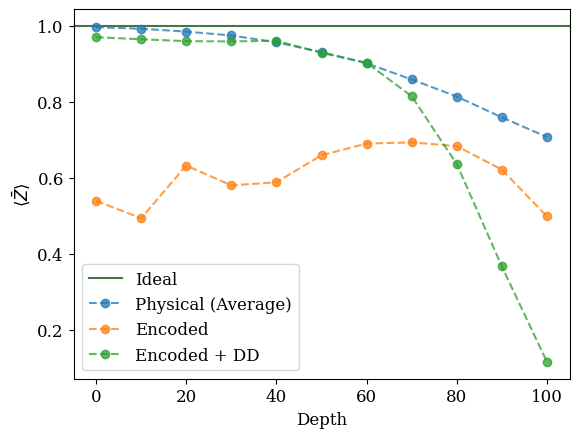

In [27]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75

plt.axhline(1.0, label="Ideal", alpha=alpha, color="xkcd:darkgreen")
plt.plot(depths, evals_raw_avg, "--o", alpha=alpha, label="Physical (Average)")
# plt.plot(depths, all_evals[121], "--o", alpha=alpha, label="Physical (Best)")
plt.plot(depths, evals_encoded, "--o", alpha=alpha, label="Encoded")
plt.plot(depths, evals_dd, "--o", alpha=alpha, label="Encoded + DD")

plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")

plt.legend();
plt.savefig(save_key + ".pdf")

## Save all data

In [28]:
import os

import pickle

In [29]:
os.mkdir(save_key)

In [30]:
np.savetxt(f"{save_key}/physical_qubits.txt", layout[n])

In [31]:
with open(f"{save_key}/expectation_values_raw.pkl", "wb") as f:
    pickle.dump(all_evals, f)

In [32]:
np.savetxt(f"{save_key}/expectation_values_encoded.txt", evals_encoded)
np.savetxt(f"{save_key}/expectation_values_encoded_dd.txt", evals_dd)